# NeuroLinkAI: Deep Learning-Driven Neuroprosthetic Control Interface

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt  # For plotting graphs
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For statistical data visualization
import tensorflow as tf  # For deep learning tasks
from scipy.fft import fft  # For performing Fast Fourier Transform (FFT)
from scipy.signal import butter, lfilter, welch  # For signal processing tasks
from sklearn.decomposition import PCA  # For dimensionality reduction using Principal Component Analysis (PCA)
from sklearn.ensemble import RandomForestClassifier  # For building a random forest classifier
from sklearn.feature_selection import SelectFromModel  # For feature selection based on model importance
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, roc_curve  # For evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize  # For data preprocessing tasks
from tensorflow.keras.callbacks import EarlyStopping  # For early stopping during model training
from tensorflow.keras.layers import Dense, LSTM  # Components for building neural networks
from tensorflow.keras.models import Sequential, load_model  # For creating and loading Keras models
from tensorflow.keras.optimizers import Adam  # Optimizer for neural network training

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning and Preprocessing

#### Loading the data

In [3]:
# File path where the dataset is located
file_path = r'C:\Users\rkpan\Desktop\Major_Project_8sem\BCI_dataset.csv'

# Loading the dataset into a DataFrame
bci_data = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the dataset
print(bci_data.head())

   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-16  
0 -2.898

In [5]:
# Display the shape of the dataset
print(bci_data.describe())

             patient           time          epoch         EEG-Fz  \
count  492048.000000  492048.000000  492048.000000  492048.000000   
mean        5.058824       0.300000     312.133578      -0.811991   
std         2.645100       0.232092     176.757760       7.345682   
min         1.000000      -0.100000       4.000000     -83.147212   
25%         3.000000       0.100000     159.750000      -4.968283   
50%         5.000000       0.300000     312.000000      -0.657985   
75%         7.000000       0.500000     465.000000       3.458858   
max         9.000000       0.700000     656.000000      56.453337   

               EEG-0          EEG-1          EEG-2          EEG-3  \
count  492048.000000  492048.000000  492048.000000  492048.000000   
mean       -0.399268      -0.669511      -0.908202      -0.607526   
std         5.758001       5.182636       5.864248       5.159808   
min       -41.675317     -33.485423     -47.021740     -38.127339   
25%        -3.791030      -3.6775

In [6]:
# Display the shape of the dataset
print(bci_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492048 entries, 0 to 492047
Data columns (total 26 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   patient  492048 non-null  int64  
 1   time     492048 non-null  float64
 2   label    492048 non-null  object 
 3   epoch    492048 non-null  int64  
 4   EEG-Fz   492048 non-null  float64
 5   EEG-0    492048 non-null  float64
 6   EEG-1    492048 non-null  float64
 7   EEG-2    492048 non-null  float64
 8   EEG-3    492048 non-null  float64
 9   EEG-4    492048 non-null  float64
 10  EEG-5    492048 non-null  float64
 11  EEG-C3   492048 non-null  float64
 12  EEG-6    492048 non-null  float64
 13  EEG-Cz   492048 non-null  float64
 14  EEG-7    492048 non-null  float64
 15  EEG-C4   492048 non-null  float64
 16  EEG-8    492048 non-null  float64
 17  EEG-9    492048 non-null  float64
 18  EEG-10   492048 non-null  float64
 19  EEG-11   492048 non-null  float64
 20  EEG-12   492048 non-null  

#### Handling Missing Values

In [7]:
# Checking for missing values in the dataset
if bci_data.isnull().values.any():
    # If missing values are found, printing the total count and removing them
    print(f"Missing values found. Total missing values: {bci_data.isnull().sum().sum()}")
    bci_data.dropna(inplace=True)  # Removing missing values
    print("Missing values removed.")
else:
    print("No missing values in the dataset.")

No missing values in the dataset.


#### Define a bandpass filter function

In [8]:
# Function to apply a bandpass filter to the data
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    # Calculate Nyquist frequency
    nyq = 0.5 * fs
    # Normalize cutoff frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Design the filter
    b, a = butter(order, [low, high], btype='band')
    # Apply the filter to the data
    y = lfilter(b, a, data)
    return y

In [9]:
# Parameters for the bandpass filter
fs = 250.0       # Sample rate in Hz
lowcut = 1.0     # Low cutoff frequency in Hz
highcut = 40.0   # High cutoff frequency in Hz

In [10]:
print("Applying bandpass filter to EEG signals.")
# Apply the bandpass filter to each EEG column
eeg_columns = [col for col in bci_data.columns if 'EEG' in col]
for col in eeg_columns:
    bci_data[col] = bandpass_filter(bci_data[col], lowcut, highcut, fs)
print("Bandpass filtering completed.")

Applying bandpass filter to EEG signals.
Bandpass filtering completed.


#### Normalize/Standardize the EEG signals

In [11]:
# Initializing a StandardScaler object
scaler = StandardScaler()

# Normalizing/standardizing EEG signal values
bci_data[eeg_columns] = scaler.fit_transform(bci_data[eeg_columns])

In [12]:
# Descriptive Analysis Post-Preprocessing
print(bci_data.describe())

             patient           time          epoch        EEG-Fz  \
count  492048.000000  492048.000000  492048.000000  4.920480e+05   
mean        5.058824       0.300000     312.133578 -1.875101e-17   
std         2.645100       0.232092     176.757760  1.000001e+00   
min         1.000000      -0.100000       4.000000 -7.082258e+00   
25%         3.000000       0.100000     159.750000 -6.042786e-01   
50%         5.000000       0.300000     312.000000 -8.697558e-03   
75%         7.000000       0.500000     465.000000  6.005302e-01   
max         9.000000       0.700000     656.000000  6.535665e+00   

              EEG-0         EEG-1         EEG-2         EEG-3         EEG-4  \
count  4.920480e+05  4.920480e+05  4.920480e+05  4.920480e+05  4.920480e+05   
mean  -8.288857e-18 -5.537938e-18 -2.791352e-17 -6.007255e-18 -1.978351e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -7.363498e+00 -5.880796e+00 -6.204150e+00 -6.242017e+00 -6.153281

In [13]:
# Display the first few rows of the preprocessed data to verify
print(bci_data.head())

   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -0.002240  0.003819 -0.000273  0.001907   
1        1 -0.096  tongue      8 -0.014703  0.026610  0.001091  0.014488   
2        1 -0.092  tongue      8 -0.040910  0.085390  0.014976  0.053822   
3        1 -0.088  tongue      8 -0.056922  0.163591  0.056277  0.132775   
4        1 -0.084  tongue      8 -0.014128  0.193240  0.122108  0.241471   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -0.002841 -0.000989  ...  0.001223  0.006141  0.000782  0.002823 -0.003305   
1 -0.016547 -0.005323  ...  0.010620  0.041255  0.006086  0.015809 -0.021676   
2 -0.033631 -0.001587  ...  0.045060  0.118435  0.016491  0.029140 -0.064067   
3  0.003389  0.064863  ...  0.128699  0.171929  0.005496 -0.011568 -0.110694   
4  0.180178  0.276945  ...  0.288449  0.061972 -0.087694 -0.175592 -0.116140   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-16  
0 -0.004

### Exploratory Data Analysis (EDA)

#### Signal Visualization

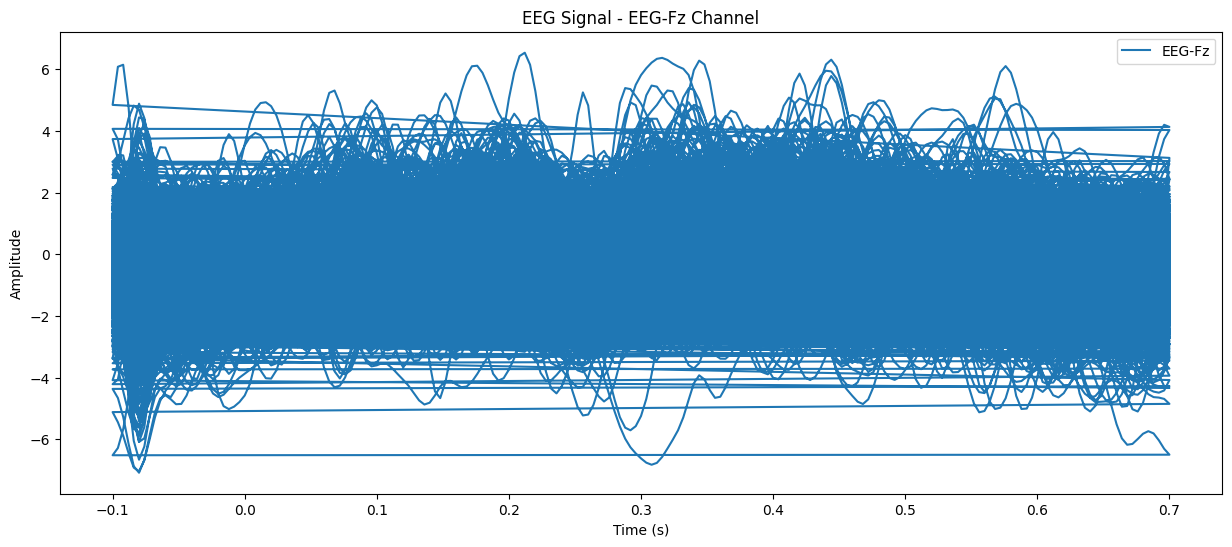

In [14]:
# Visualizing the EEG signal for EEG-Fz channel over time
plt.figure(figsize=(15, 6))
plt.plot(bci_data['time'], bci_data['EEG-Fz'], label='EEG-Fz')
plt.title('EEG Signal - EEG-Fz Channel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Frequency Analysis

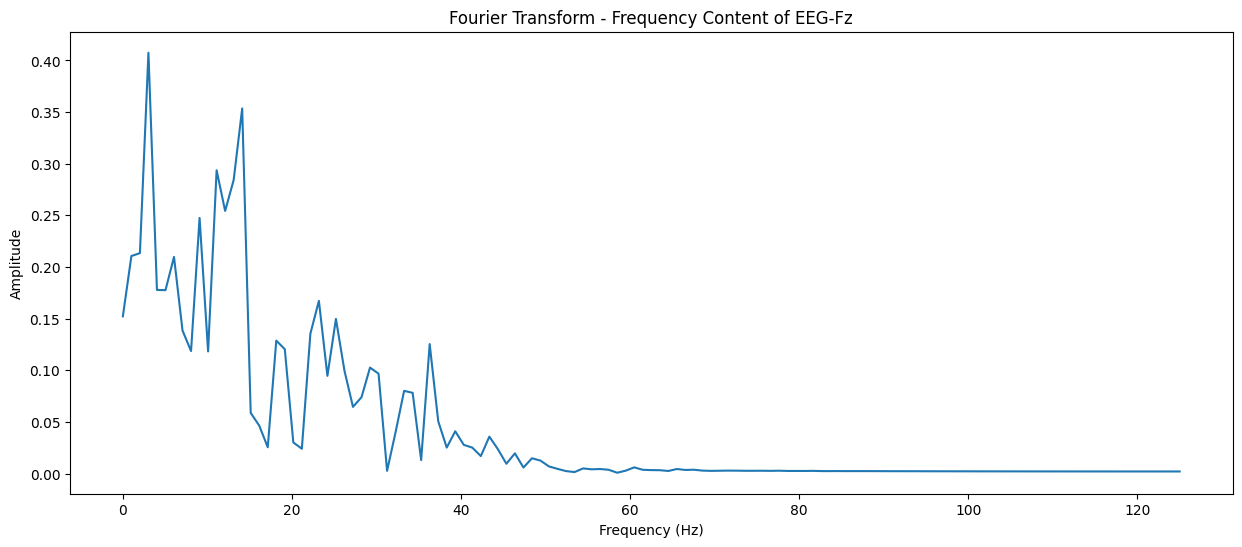

In [15]:
# Selecting a sample EEG signal (first 1 second) from EEG-Fz channel
eeg_signal = bci_data['EEG-Fz'].values[:250]  # Sampling 250 points for 1 second at fs=250Hz

# Performing a Fourier Transform to analyze frequency content
yf = fft(eeg_signal)
xf = np.linspace(0.0, 1.0/(2.0*(1/fs)), 125)  # Considering only positive frequencies

plt.figure(figsize=(15, 6))
plt.plot(xf, 2.0/250 * np.abs(yf[:125]))
plt.title('Fourier Transform - Frequency Content of EEG-Fz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

#### Spectral Power Density Plot

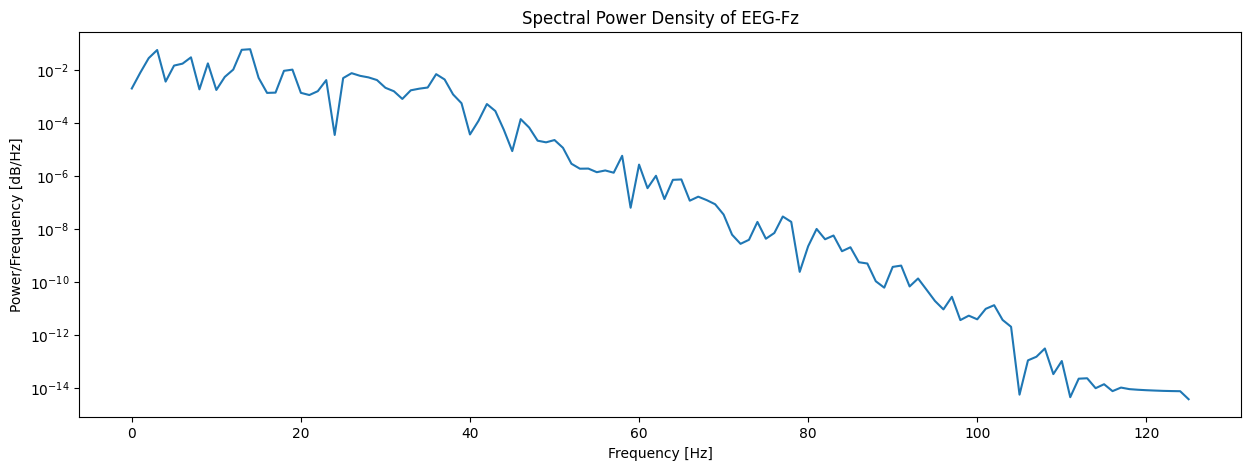

In [16]:
# EEG data is sampled at 250 Hz
fs = 250  # Sample rate
eeg_signal = bci_data['EEG-Fz'][:fs]  # Selecting 1 second of EEG data

# Compute the Power Spectral Density (PSD) using Welch's method
frequencies, power_density = welch(eeg_signal, fs, nperseg=fs)

plt.figure(figsize=(15, 5))
plt.semilogy(frequencies, power_density)
plt.title('Spectral Power Density of EEG-Fz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.show()

#### Correlation Matrices

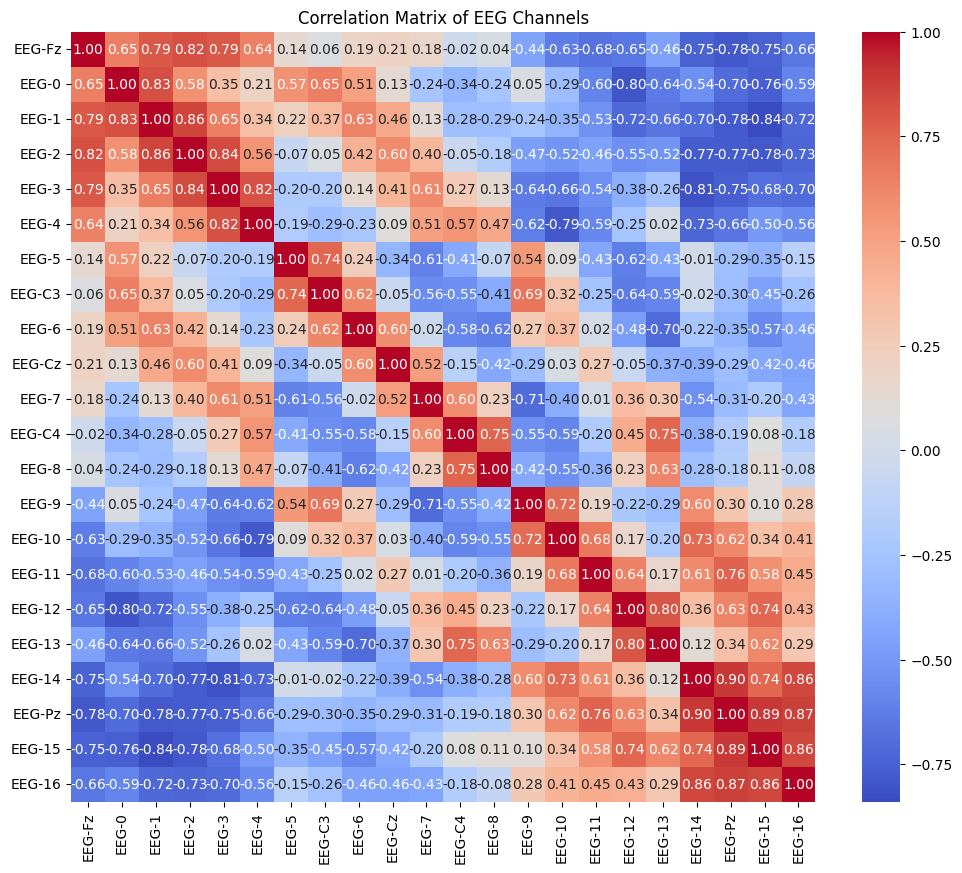

In [17]:
# Calculating the correlation matrix for EEG signal channels
correlation_matrix = bci_data[eeg_columns].corr()

# Visualizing the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of EEG Channels')
plt.show()

### Feature Engineering and Selection

#### Feature Extraction

In [18]:
# Define frequency bands
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}

# Initialize a DataFrame to store features
eeg_features = pd.DataFrame(index=bci_data.index)

In [19]:
# Extract power in each frequency band using Welch's method
for band, (low_freq, high_freq) in bands.items():
    # Compute the Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(bci_data[eeg_columns], fs=fs, nperseg=1024)
    # Find intersecting frequencies within the band
    freq_res = freqs[1] - freqs[0]  # Frequency resolution
    idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
    # Sum the power in the band
    band_power = psd[:, idx_band].sum(axis=1) * freq_res
    # Add band power as a feature to the DataFrame
    eeg_features[f'{band}_band_power'] = band_power

In [20]:
# Print the first few rows of the extracted features
print(eeg_features.head())

   Delta_band_power  Theta_band_power  Alpha_band_power  Beta_band_power  \
0               0.0               0.0      3.937008e-07         0.000001   
1               0.0               0.0      3.785060e-05         0.000057   
2               0.0               0.0      7.978704e-04         0.000492   
3               0.0               0.0      6.558786e-03         0.001169   
4               0.0               0.0      2.637428e-02         0.001403   

   Gamma_band_power  
0          0.000007  
1          0.000363  
2          0.003403  
3          0.009009  
4          0.004192  


#### Dimensionality Reduction

In [21]:
# Normalize features before PCA
scaler = StandardScaler()  # Initialize StandardScaler object
eeg_features_scaled = scaler.fit_transform(eeg_features)  # Normalize features using StandardScaler

In [22]:
# Apply PCA
pca = PCA(n_components=0.95)  # Initialize PCA object, keeping 95% of the variance
eeg_features_pca = pca.fit_transform(eeg_features_scaled)  # Apply PCA to scaled features

In [23]:
# Convert to DataFrame
eeg_features_pca_df = pd.DataFrame(eeg_features_pca, index=bci_data.index)  # Convert PCA-transformed features to DataFrame

# Print the explained variance
print(f"Explained variance by component: {pca.explained_variance_ratio_}")  # Print explained variance by each principal component
print(eeg_features_pca_df.head()) 

Explained variance by component: [0.69012969 0.2594621  0.05040821]
          0         1         2
0 -1.064446 -0.108156 -0.053895
1 -1.063614 -0.108530 -0.053703
2 -1.056044 -0.110426 -0.051340
3 -1.035815 -0.101296 -0.041827
4 -1.009552 -0.038666 -0.029701


#### Feature Selection

In [24]:
# `target` is the column in your DataFrame with the labels for each movement intention
target = bci_data['label'].values  # Extract labels from the 'label' column of the DataFrame

In [25]:
# Fit a Random Forest to compute feature importances
forest = RandomForestClassifier(n_estimators=100)  # Initialize Random Forest classifier with 100 trees
forest.fit(eeg_features_scaled, target)  # Fit the Random Forest model to the scaled features and labels

RandomForestClassifier()

In [26]:
# Select features based on importance
selector = SelectFromModel(forest, prefit=True)  # Initialize feature selector using the fitted Random Forest
eeg_features_selected = selector.transform(eeg_features_scaled)  # Select important features

In [27]:
# Convert to DataFrame
eeg_features_selected_df = pd.DataFrame(eeg_features_selected, index=bci_data.index)  # Convert selected features to DataFrame

# Print the shape of the selected features
print(eeg_features_selected_df.shape)  # Print the shape of the DataFrame containing selected features

(492048, 3)


### Model Development and Training

#### Model Selection

In [28]:
n_features = eeg_features_selected_df.shape[1]  # Number of features
n_timesteps = 1

In [29]:
# Define the LSTM model
model = Sequential()  # Initialize a sequential model
model.add(LSTM(50, input_shape=(n_timesteps, n_features), return_sequences=True))  # Add first LSTM layer with 50 units
model.add(LSTM(50))  # Add second LSTM layer with 50 units
model.add(Dense(1, activation='sigmoid'))  # Add output layer with sigmoid activation function (for binary classification)

In [30]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model with Adam optimizer, binary cross-entropy loss function, and accuracy metric
# Print model summary
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

In [31]:
# Convert string labels to integers
label_encoder = LabelEncoder()  # Initialize LabelEncoder object
integer_encoded = label_encoder.fit_transform(bci_data['label'].values)  # Encode string labels to integers

In [32]:
# One-hot encode
onehot_encoder = OneHotEncoder(sparse=False)  # Initialize OneHotEncoder object
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)  # Reshape integer encoded labels
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)  # One-hot encode integer encoded labels

In [33]:
# Sequence_length and n_features are defined as before
sequence_length = 100  # Length of each sequence
n_features = eeg_features_selected_df.shape[1]  # Number of features
X = np.array([eeg_features_selected_df.iloc[i:i+sequence_length].values for i in range(len(eeg_features_selected_df) - sequence_length)])  # Create input sequences
y = onehot_encoded[sequence_length:]  # Assign one-hot encoded labels

In [34]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # Split data into training and temporary sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Further split temporary set into validation and test sets

In [35]:
# Build the LSTM model
model = Sequential()  # Initialize sequential model
model.add(LSTM(50, input_shape=(sequence_length, n_features), return_sequences=True))  # Add first LSTM layer with 50 units
model.add(LSTM(50))  # Add second LSTM layer with 50 units
num_classes = y_train.shape[1]  # Number of classes
model.add(Dense(num_classes, activation='softmax'))  # Add output layer with softmax activation function (for multi-class classification)

In [36]:
# Compile the model
model.compile(loss='categorical_crossentropy',  # Specify loss function
              optimizer=Adam(learning_rate=0.001),  # Specify optimizer
              metrics=['accuracy'])  # Specify evaluation metrics

In [37]:
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (1 for updates, 0 for silent)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [38]:
# Train the model with the EarlyStopping callback
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=70,  # Number of epochs for training
    batch_size=512,  # Size of mini-batches
    callbacks=[early_stopping_callback],  # Callbacks to apply during training
    verbose=1  # Verbosity mode (1 for updates, 0 for silent)
)

Epoch 1/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 334s 571ms/step - accuracy: 0.2737 - loss: 1.3828 - val_accuracy: 0.2878 - val_loss: 1.3766
Epoch 2/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 302s 524ms/step - accuracy: 0.2902 - loss: 1.3754 - val_accuracy: 0.2956 - val_loss: 1.3711
Epoch 3/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 303s 524ms/step - accuracy: 0.2982 - loss: 1.3673 - val_accuracy: 0.3021 - val_loss: 1.3607
Epoch 4/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 309s 536ms/step - accuracy: 0.3090 - loss: 1.3589 - val_accuracy: 0.3167 - val_loss: 1.3496
Epoch 5/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 302s 524ms/step - accuracy: 0.3277 - loss: 1.3385 - val_accuracy: 0.3418 - val_loss: 1.3217
Epoch 6/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 303s 526ms/step - accuracy: 0.3452 - loss: 1.3230 - val_accuracy: 0.3640 - val_loss: 1.2962
Epoch 7/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 305s 528ms/step - accuracy: 0.3740 - loss: 1.2836 - val_accuracy: 0.3902 - val_loss: 1.2635
Epoch 8/70
577/577 ━━━━━━━━━━━━━━━━━━━━ 303s 526ms/step - accuracy: 0.4024 -

In [39]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)  # Evaluate model performance on test data
print(f"Test accuracy: {accuracy*100:.2f}%")  # Print test accuracy

3075/3075 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step - accuracy: 0.8275 - loss: 0.4373
Test accuracy: 82.75%


In [40]:
#saving the model
model.save('NeuroLinkAI_model.h5')

#### Model Training and loss Visualisation

In [41]:
plt.style.use('seaborn-darkgrid')

In [42]:
# Increase the default font sizes for readability
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=14)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)  # fontsize of the tick labels
plt.rc('ytick', labelsize=10)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)  # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

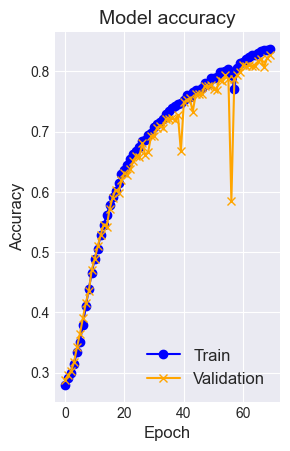

In [44]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linestyle='-', marker='x')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

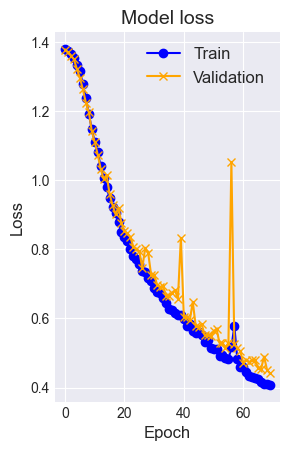

In [45]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='blue', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation', color='orange', linestyle='-', marker='x')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

In [46]:
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()  # Display the plot

<Figure size 640x480 with 0 Axes>

### Hyperparameter Tuning with Grid Search

#### Loading the pre saved model

In [47]:
model_path = 'NeuroLinkAI_model.h5'  # Path to the saved model file
model = load_model(model_path)  # Load the saved model

#### Hyperparameter Tuning

In [48]:
new_learning_rates = [0.0001, 0.00001]  # List of new learning rates to try
new_batch_sizes = [256, 512, 1024]  # List of new batch sizes to try

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Quantity to be monitored for improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [49]:
best_lr = None  # Initialize variable to store the best learning rate
best_batch_size = None  # Initialize variable to store the best batch size
best_val_loss = float('inf')  # Initialize variable to store the best validation loss (set to positive infinity initially)

In [50]:
# Iterate over each combination of new learning rates and batch sizes
for lr in new_learning_rates:  # Iterate over each new learning rate
    for batch_size in new_batch_sizes:  # Iterate over each new batch size
        # Load the model for each combination to reset its state
        model = load_model(model_path)  # Load the saved model
        
        # Compile the model with the new learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  # Initialize Adam optimizer with new learning rate
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model
        
        # Train the model with new hyperparameters
        history = model.fit(
            X_train, y_train,  # Training data
            validation_data=(X_val, y_val),  # Validation data
            epochs=10,  # Number of epochs for training (adjust based on your needs)
            batch_size=batch_size,  # Batch size
            callbacks=[early_stopping],  # Callbacks to apply during training
            verbose=1  # Set to 0 to suppress output
        )

        # Check if the validation loss has improved
        min_val_loss = min(history.history['val_loss'])  # Get the minimum validation loss from the training history
        if min_val_loss < best_val_loss:  # If the new minimum validation loss is lower than the previous best
            best_val_loss = min_val_loss  # Update the best validation loss
            best_lr = lr  # Update the best learning rate
            best_batch_size = batch_size  # Update the best batch size

Epoch 1/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 325s 279ms/step - accuracy: 0.8497 - loss: 0.3167 - val_accuracy: 0.8377 - val_loss: 0.2791
Epoch 2/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 300s 260ms/step - accuracy: 0.8550 - loss: 0.2515 - val_accuracy: 0.8397 - val_loss: 0.2507
Epoch 3/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 309s 268ms/step - accuracy: 0.8558 - loss: 0.2272 - val_accuracy: 0.8400 - val_loss: 0.2341
Epoch 4/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 309s 268ms/step - accuracy: 0.8581 - loss: 0.2100 - val_accuracy: 0.8402 - val_loss: 0.2227
Epoch 5/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 307s 267ms/step - accuracy: 0.8598 - loss: 0.1985 - val_accuracy: 0.8415 - val_loss: 0.2124
Epoch 6/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 308s 267ms/step - accuracy: 0.8595 - loss: 0.1897 - val_accuracy: 0.8436 - val_loss: 0.2043
Epoch 7/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 312s 270ms/step - accuracy: 0.8619 - loss: 0.1820 - val_accuracy: 0.8445 - val_loss: 0.1988
Epoch 8/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 317s 275ms/step - ac

Epoch 1/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 368s 631ms/step - accuracy: 0.8515 - loss: 0.3247 - val_accuracy: 0.8377 - val_loss: 0.2974
Epoch 2/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 342s 593ms/step - accuracy: 0.8546 - loss: 0.2709 - val_accuracy: 0.8377 - val_loss: 0.2721
Epoch 3/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 349s 604ms/step - accuracy: 0.8553 - loss: 0.2477 - val_accuracy: 0.8387 - val_loss: 0.2554
Epoch 4/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 353s 611ms/step - accuracy: 0.8567 - loss: 0.2309 - val_accuracy: 0.8400 - val_loss: 0.2436
Epoch 5/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 345s 599ms/step - accuracy: 0.8578 - loss: 0.2198 - val_accuracy: 0.8405 - val_loss: 0.2343


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8526 - loss: 0.3333 - val_accuracy: 0.8381 - val_loss: 0.3124
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8559 - loss: 0.2868 - val_accuracy: 0.8381 - val_loss: 0.2911
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.8560 - loss: 0.2662 - val_accuracy: 0.8386 - val_loss: 0.2761
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8565 - loss: 0.2526 - val_accuracy: 0.8396 - val_loss: 0.2649
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.8573 - loss: 0.2411 - val_accuracy: 0.8393 - val_loss: 0.2559


Epoch 1/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 409s 352ms/step - accuracy: 0.8503 - loss: 0.3504 - val_accuracy: 0.8363 - val_loss: 0.3435
Epoch 2/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 626s 543ms/step - accuracy: 0.8545 - loss: 0.3204 - val_accuracy: 0.8378 - val_loss: 0.3284
Epoch 3/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 606s 525ms/step - accuracy: 0.8550 - loss: 0.3062 - val_accuracy: 0.8381 - val_loss: 0.3177
Epoch 4/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 675s 584ms/step - accuracy: 0.8544 - loss: 0.2965 - val_accuracy: 0.8385 - val_loss: 0.3088
Epoch 5/10
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 525s 455ms/step - accuracy: 0.8554 - loss: 0.2871 - val_accuracy: 0.8387 - val_loss: 0.3011


Epoch 1/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 412s 705ms/step - accuracy: 0.8485 - loss: 0.3544 - val_accuracy: 0.8361 - val_loss: 0.3514
Epoch 2/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 900s 2s/step - accuracy: 0.8530 - loss: 0.3304 - val_accuracy: 0.8370 - val_loss: 0.3391
Epoch 3/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 900s 2s/step - accuracy: 0.8532 - loss: 0.3194 - val_accuracy: 0.8375 - val_loss: 0.3304
Epoch 4/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step - accuracy: 0.8543 - loss: 0.3101 - val_accuracy: 0.8375 - val_loss: 0.3233
Epoch 5/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 968s 2s/step - accuracy: 0.8542 - loss: 0.3031 - val_accuracy: 0.8384 - val_loss: 0.3172


Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 867s 3s/step - accuracy: 0.8481 - loss: 0.3569 - val_accuracy: 0.8360 - val_loss: 0.3578
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.8547 - loss: 0.3376 - val_accuracy: 0.8368 - val_loss: 0.3476
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.8556 - loss: 0.3276 - val_accuracy: 0.8371 - val_loss: 0.3404
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.8543 - loss: 0.3203 - val_accuracy: 0.8377 - val_loss: 0.3346
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.8548 - loss: 0.3140 - val_accuracy: 0.8378 - val_loss: 0.3297


In [51]:
# Print the best hyperparameters found
print(f'Best validation loss achieved: {best_val_loss}')  # Print the best validation loss
print(f'Best learning rate: {best_lr}')  # Print the best learning rate
print(f'Best batch size: {best_batch_size}')  # Print the best batch size

Best validation loss achieved: 0.18828319013118744
Best learning rate: 0.0001
Best batch size: 256


#### Roc Curve

In [52]:

y_pred_probs = model.predict(X_test)  # Get predicted probabilities from the model for the test set

# Binarize the output labels for multi-class ROC curve
n_classes = y_pred_probs.shape[1]  # Number of classes
y_test_binarized = label_binarize(y_test, classes=[*range(n_classes)])  # Binarize the true labels for multi-class ROC curve

3075/3075 ━━━━━━━━━━━━━━━━━━━━ 166s 54ms/step


In [53]:
# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area Under Curve (AUC)
for i in range(n_classes):  # Iterate over each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])  # Compute ROC curve
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute AUC

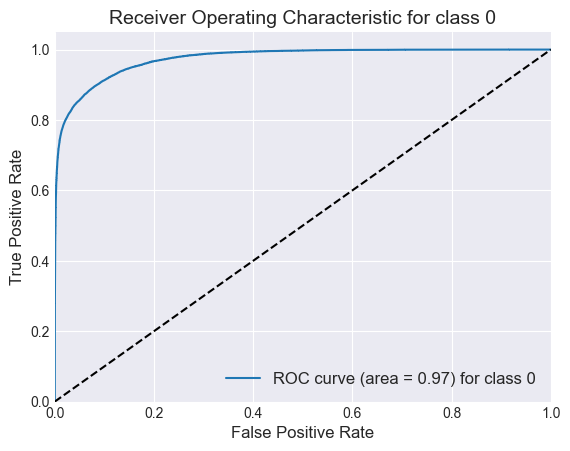

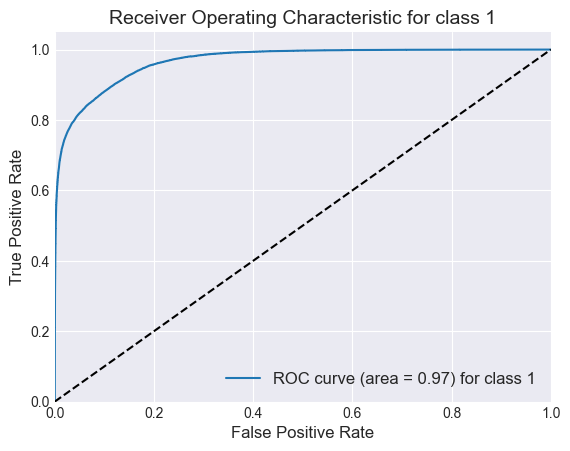

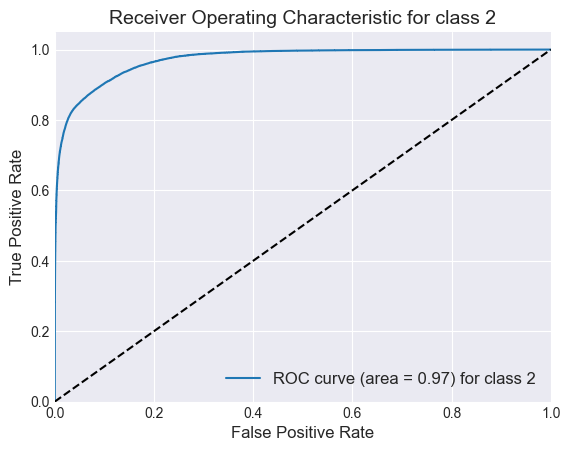

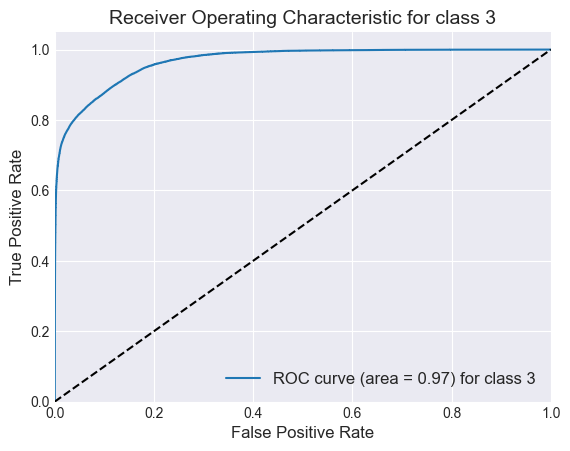

In [54]:
# Plotting ROC Curve for each class
for i in range(n_classes):  # Iterate over each class
    plt.figure()  # Create a new figure
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %i' % (roc_auc[i], i))  # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
    plt.xlim([0.0, 1.0])  # Set x-axis limits
    plt.ylim([0.0, 1.05])  # Set y-axis limits
    plt.xlabel('False Positive Rate')  # Set x-axis label
    plt.ylabel('True Positive Rate')  # Set y-axis label
    plt.title('Receiver Operating Characteristic for class %i' % i)  # Set title
    plt.legend(loc="lower right")  # Add legend
    plt.show()  # Show plot

#### Evaluation Results

In [55]:
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate the metrics
precision = precision_score(y_test, y_pred, average='macro') * 100
recall = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
accuracy = accuracy_score(y_test, y_pred) * 100  # Overall accuracy

# Print the calculated metrics in percentage
print(f'Overall Accuracy: {accuracy:.2f}%')
print(f'Precision (Macro): {precision:.2f}%')
print(f'Recall (Macro): {recall:.2f}%')
print(f'F1 Score (Macro): {f1:.2f}%')


Overall Accuracy: 78.99%
Precision (Macro): 90.98%
Recall (Macro): 78.94%
F1 Score (Macro): 84.49%


#### Evaluation Graph

In [56]:
# Extract accuracy and loss history from the training history object
training_accuracy = history.history['accuracy']  # Training accuracy
validation_accuracy = history.history['val_accuracy']  # Validation accuracy
training_loss = history.history['loss']  # Training loss
validation_loss = history.history['val_loss']  # Validation loss
epochs = range(1, len(training_accuracy) + 1)  # Number of epochs

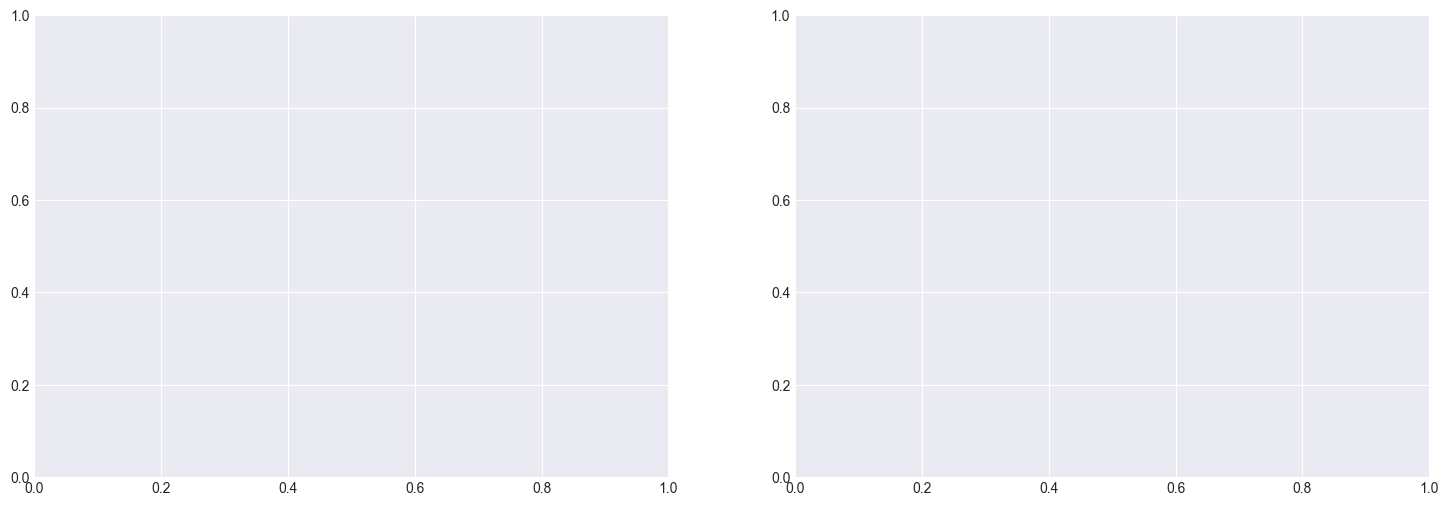

In [57]:
# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # Create a figure with two subplots

In [58]:
# Plot training and validation loss
ax2.plot(epochs, training_loss, 'bo-', label='Training Loss')  # Plot training loss
ax2.plot(epochs, validation_loss, 'ro-', label='Validation Loss')  # Plot validation loss
ax2.set_title('Training and Validation Loss')  # Set title for the subplot
ax2.set_xlabel('Epochs')  # Set x-axis label
ax2.set_ylabel('Loss')  # Set y-axis label
ax2.legend()  # Add legend to the subplot

In [59]:
# Display the plot
plt.suptitle('Model Training and Validation Metrics')  # Set title for the overall plot
plt.show()  # Show the plot

<Figure size 640x480 with 0 Axes>

### Final Model Saving

In [60]:
# Define the path to save the model
model_path = 'final_NeuroLinkAI_model.h5'  

# Save the model
model.save(model_path)  # Save the model to the specified path

# Print a message confirming the model is saved
print(f'Model saved to {model_path}')  # Print the path where the model is saved
print("Model saved successfully and project over")  # Print a success message

Model saved to final_NeuroLinkAI_model.h5
Model saved successfully and project over
